# Diffusion Model (UViT) with triangles

## Imports

In [ ]:
from collections.abc import Callable, Mapping

import inspect

import functools

from clu import metric_writers
import numpy as np
import jax
import flax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import optax
import orbax.checkpoint as ocp

import h5py
import natsort
import tensorflow as tf
from scipy.ndimage import geometric_transform
from scipy.ndimage import gaussian_filter

from swirl_dynamics import templates
from swirl_dynamics.lib import diffusion as dfn_lib
from swirl_dynamics.lib import solvers as solver_lib
from swirl_dynamics.projects import probabilistic_diffusion as dfn


import gc
import os
import sys

2025-01-31 13:03:31.638666: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-31 13:03:31.689231: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-31 13:03:31.704559: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-31 13:03:34.008469: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Training process

### Training Dataset

In [2]:
# Parameters for the computational task.

L = 4 # number of levels (even number)
s = 5 # leaf size
r = 3 # rank

# Discretization of Omega (n_eta * n_eta).
neta = (2**L)*s

# Number of sources/detectors (n_sc).
# Discretization of the domain of alpha in polar coordinates (n_theta * n_rho).
# For simplicity, these values are set equal (n_sc = n_theta = n_rho), facilitating computation.
nx = (2**L)*s

# Standard deviation for the Gaussian blur.
blur_sigma = 0.5

# Number of training datapoints.
NTRAIN = 21000

In [3]:
name = 'Data/traindata_3510tri'

# Loading and preprocessing perturbation data (eta)
with h5py.File(f'{name}/eta.h5', 'r') as f:
    # Read eta data, apply Gaussian blur, and reshape
    eta_re = f[list(f.keys())[0]][:NTRAIN, :].reshape(-1, neta, neta)
    blur_fn = lambda x: gaussian_filter(x, sigma=blur_sigma)
    eta_re = np.stack([blur_fn(eta_re[i, :, :].T) for i in range(NTRAIN)]).astype('float32')
    
mean_eta = np.mean(eta_re, axis = 0)
eta_re -= mean_eta
std_eta = np.std(eta_re)
eta_re /= std_eta

# Loading and preprocessing scatter data (Lambda)
with h5py.File(f'{name}/scatter.h5', 'r') as f:
    keys = natsort.natsorted(f.keys())

    # Process real part of scatter data
    tmp1 = f[keys[3]][:NTRAIN, :]
    tmp2 = f[keys[4]][:NTRAIN, :]
    tmp3 = f[keys[5]][:NTRAIN, :]
    scatter_re = np.stack((tmp1, tmp2, tmp3), axis=-1)

    # Process imaginary part of scatter data
    tmp1 = f[keys[0]][:NTRAIN, :]
    tmp2 = f[keys[1]][:NTRAIN, :]
    tmp3 = f[keys[2]][:NTRAIN, :]
    scatter_im = np.stack((tmp1, tmp2, tmp3), axis=-1)
    
    # Combine real and imaginary parts
    scatter = np.stack((scatter_re, scatter_im), axis=-2).astype('float32')

mean0, std0 = np.mean(scatter[:,:,:,0]), np.std(scatter[:,:,:,0])
mean1, std1 = np.mean(scatter[:,:,:,1]), np.std(scatter[:,:,:,1])
mean2, std2 = np.mean(scatter[:,:,:,2]), np.std(scatter[:,:,:,2])

scatter[:,:,:,0] -= mean0
scatter[:,:,:,0] /= std0
scatter[:,:,:,1] -= mean1
scatter[:,:,:,1] /= std1
scatter[:,:,:,2] -= mean2
scatter[:,:,:,2] /= std2

# Clean up temporary variables to free memory
del scatter_re, scatter_im, tmp1, tmp2, tmp3

In [4]:
scatter_train = np.reshape(scatter[:,:,:],(NTRAIN,80,80,6))
eta_re_train = eta_re.reshape(-1, 80, 80, 1)
assert eta_re_train.shape == (NTRAIN, 80, 80, 1)
assert scatter_train.shape == (NTRAIN, 80, 80, 6)

In [5]:
# To avoid tf to use GPU memory
tf.config.set_visible_devices([], device_type='GPU')

batch_size = 16
dict_data = {"x": eta_re_train}
dict_data["cond"] = {"channel:scatter": scatter_train}
dataset = tf.data.Dataset.from_tensor_slices(dict_data)
dataset = dataset.repeat()
dataset = dataset.batch(batch_size)
dataset = dataset.prefetch(tf.data.AUTOTUNE)
dataset = eval_dataloader = dataset.as_numpy_iterator()

I0000 00:00:1738350297.187057 3899284 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-01-31 13:04:57.306662: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [6]:
data_std = np.std(eta_re_train)
data_size = len(eta_re_train)

### Architecture

In [7]:
cond_denoiser_model = dfn_lib.unets.PreconditionedDenoiser(
    out_channels=1,
    num_channels=(64, 128),
    downsample_ratio=(2, 2),
    num_blocks=4,
    noise_embed_dim=128,
    padding="SAME",
    use_attention=True,
    use_position_encoding=True,
    num_heads=8,
    sigma_data=data_std,
    cond_resize_method="cubic",
    cond_embed_dim=128,
)

In [8]:
diffusion_scheme = dfn_lib.Diffusion.create_variance_preserving(
    sigma=dfn_lib.tangent_noise_schedule(),
    data_std=data_std,
)

cond_model = dfn.DenoisingModel(
    input_shape=(80, 80, 1),
    # `cond_shape` must agree with the expected structure and shape
    # (without the batch dimension) of the `cond` input.
    cond_shape={"channel:scatter": (80, 80, 6)},
    denoiser=cond_denoiser_model,
    noise_sampling=dfn_lib.time_uniform_sampling(
        diffusion_scheme, clip_min=1e-4, uniform_grid=True,
    ),
    noise_weighting=dfn_lib.edm_weighting(data_std=data_std),
)

In [9]:
# rm -R -f $cond_workdir  # optional: clear the working directory

In [10]:
epochs = 100
num_train_steps = data_size * epochs // batch_size  #@param
cond_workdir = os.path.abspath('') + "/tmp/diffusion_conditional_triangles"
initial_lr = 1e-5 #@param
peak_lr = 5e-4 #@pawram
warmup_steps = num_train_steps // 20  #@param
end_lr = 1e-7 #@param
ema_decay = 0.999  #@param
ckpt_interval = 2000 #@param
max_ckpt_to_keep = 3 #@param

### Training

In [11]:
cond_trainer = dfn.DenoisingTrainer(
    model=cond_model,
    rng=jax.random.PRNGKey(888),
    optimizer=optax.adam(
        learning_rate=optax.warmup_cosine_decay_schedule(
            init_value=initial_lr,
            peak_value=peak_lr,
            warmup_steps=warmup_steps,
            decay_steps=num_train_steps,
            end_value=end_lr,
        ),
    ),
    ema_decay=ema_decay,
)

In [12]:
templates.run_train(
    train_dataloader=dataset,
    trainer=cond_trainer,
    workdir=cond_workdir,
    total_train_steps=num_train_steps,
    metric_writer=metric_writers.create_default_writer(
        cond_workdir, asynchronous=False
    ),
    metric_aggregation_steps=100,
    eval_dataloader=eval_dataloader,
    eval_every_steps = 1000,
    num_batches_per_eval = 2,
    callbacks=(
        templates.TqdmProgressBar(
            total_train_steps=num_train_steps,
            train_monitors=("train_loss",),
        ),
        templates.TrainStateCheckpoint(
            base_dir=cond_workdir,
            options=ocp.CheckpointManagerOptions( 
                save_interval_steps=ckpt_interval, max_to_keep=max_ckpt_to_keep
            ),
        ),
    ),
)

  0%|          | 0/131250 [00:00<?, ?step/s]

## Inference
### Test Dataset

In [32]:
# loading test data
NTEST = 50
name = 'Data/testdata_3510tri'

# Loading and preprocessing perturbation data (eta)
with h5py.File(f'{name}/eta.h5', 'r') as f:
    # Read eta data, apply Gaussian blur, and reshape
    eta_re = f[list(f.keys())[0]][:NTEST, :].reshape(-1, neta, neta)
    blur_fn = lambda x: gaussian_filter(x, sigma=blur_sigma)
    eta_re = np.stack([blur_fn(eta_re[i, :, :].T) for i in range(NTEST)]).astype('float32')

# Loading and preprocessing scatter data (Lambda)
with h5py.File(f'{name}/scatter.h5', 'r') as f:
    keys = natsort.natsorted(f.keys())

    # Process real part of scatter data
    tmp1 = f[keys[3]][:NTEST, :]
    tmp2 = f[keys[4]][:NTEST, :]
    tmp3 = f[keys[5]][:NTEST, :]
    scatter_re = np.stack((tmp1, tmp2, tmp3), axis=-1)

    # Process imaginary part of scatter data
    tmp1 = f[keys[0]][:NTEST, :]
    tmp2 = f[keys[1]][:NTEST, :]
    tmp3 = f[keys[2]][:NTEST, :]
    scatter_im = np.stack((tmp1, tmp2, tmp3), axis=-1)
    
    # Combine real and imaginary parts
    scatter_t = np.stack((scatter_re, scatter_im), axis=-2).astype('float32')
    
scatter_t[:,:,:,0] -= mean0
scatter_t[:,:,:,0] /= std0
scatter_t[:,:,:,1] -= mean1
scatter_t[:,:,:,1] /= std1
scatter_t[:,:,:,2] -= mean2
scatter_t[:,:,:,2] /= std2

# Clean up temporary variables to free memory
del scatter_re, scatter_im, tmp1, tmp2, tmp3

In [33]:
scatter_test = np.reshape(scatter_t[:,:,:],(NTEST,80,80,6))
eta_re_test = eta_re.reshape(-1, 80, 80, 1)
assert eta_re_test.shape == (NTEST, 80, 80, 1)
assert scatter_test.shape == (NTEST, 80, 80, 6)

In [ ]:
# Uncomment to add noise to the scatter conditional
#scatter_test = scatter_test + 0.2*np.random.normal(size=scatter_test.shape)

In [34]:
trained_state = dfn.DenoisingModelTrainState.restore_from_orbax_ckpt(
    f"{cond_workdir}/checkpoints", step=None
)

In [35]:
# Construct the inference function
cond_denoise_fn = dfn.DenoisingTrainer.inference_fn_from_state_dict(
    trained_state, use_ema=True, denoiser=cond_denoiser_model
)

In [36]:
cond_sampler = dfn_lib.SdeSampler(
    input_shape=(80, 80, 1),
    integrator=solver_lib.EulerMaruyama(),
    tspan=dfn_lib.exponential_noise_decay(
        diffusion_scheme, num_steps=256, end_sigma=1e-3,
    ),
    scheme=diffusion_scheme,
    denoise_fn=cond_denoise_fn,
    guidance_transforms=(),
    apply_denoise_at_end=True,
    return_full_paths=False,
)

In [37]:
num_samples_per_cond = 50

generate = jax.jit(
    functools.partial(cond_sampler.generate, num_samples_per_cond)
)

### Sampling

In [38]:
batch_size_test = 5
dict_data_test = {}
dict_data_test["cond"] = {"channel:scatter": scatter_test}
dataset_test = tf.data.Dataset.from_tensor_slices(dict_data_test)
dataset_test = dataset_test.batch(batch_size_test)
dataset_test = dataset_test.prefetch(tf.data.AUTOTUNE)
dataset_test = dataset_test.as_numpy_iterator()

In [39]:
eta_pred = np.zeros((NTEST, num_samples_per_cond, neta, neta, 1))

b = 0
for batch in dataset_test:
    #for i in range(10):
    print(f"\rProcessing batch {b + 1} / {NTEST//batch_size_test}", end='', flush=True)
    cond_samples = jax.device_get(jax.vmap(generate, in_axes=(0, 0, None))(
        jax.random.split(jax.random.PRNGKey(888), batch_size_test),
        batch["cond"],
        None,  # Guidance inputs = None since no guidance transforms involved
    ))
    #print(b)
    eta_pred[b*batch_size_test:(b+1)*batch_size_test,:,:,:,:] = cond_samples*std_eta+mean_eta[:, :, jnp.newaxis]
    b += 1

Processing batch 10 / 10

### Plotting samples

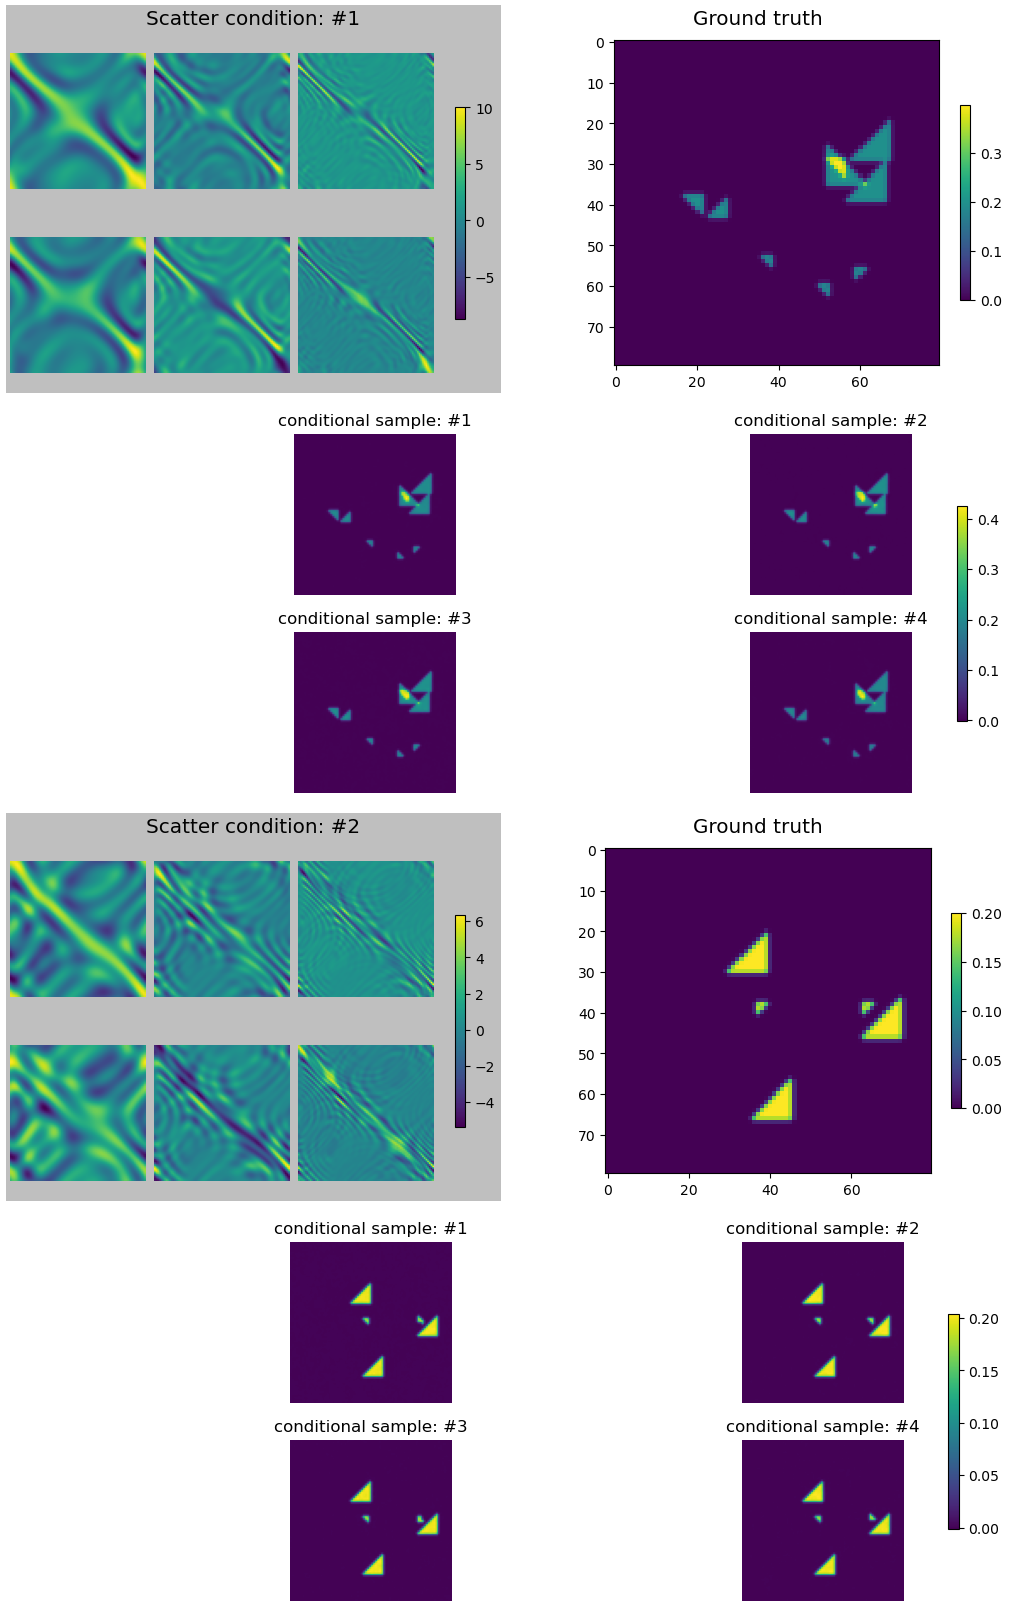

In [40]:
num_samples_per_cond_plot = 4
fig = plt.figure(layout='constrained', figsize=(10, 16))
subfigs = fig.subfigures(2, 1, wspace=0.07)
for i in range(2):
    #subfig = fig.subfigures(layout='constrained', figsize=(10, 4))
    subfigsnest = subfigs[i].subfigures(2, 1)#, wspace=0.1)
    #print(subfigs.shape)
    subfigsnest1 = subfigsnest[0].subfigures(1, 2)#, height_ratios=[1, 1.4])
    axsLeft = subfigsnest1[0].subplots(2,3)
    subfigsnest1[0].set_facecolor('0.75')
    l = 0
    for j in range(2):
        for k in range(3):
            im = axsLeft[j,k].imshow(scatter_test[i, :, :, l])#,vmin=-2.5, vmax=2.5)
            #print(test_batch_cond_denorm[i, :, :, l].shape)
            l += 1
            axsLeft[j,k].axis("off")
    subfigsnest1[0].suptitle(f"Scatter condition: #{i + 1}", fontsize='x-large')
    subfigsnest1[0].colorbar(im,shrink=0.6, ax=axsLeft, location='right')
    
    axsRight = subfigsnest1[1].subplots(1, 1)
    im_eta = axsRight.imshow(eta_re_test[i, :, :, 0])
    
    #subfigs[1].set_facecolor('0.85')
    #subfigs[1].colorbar(pc, shrink=0.6, ax=axsRight)
    subfigsnest1[1].suptitle('Ground truth', fontsize='x-large')
    subfigsnest1[1].colorbar(im_eta,shrink=0.6, ax=axsRight)
    #fig.suptitle('Scatter and ground truth', fontsize='xx-large')
    
    # Plot generated samples.
    ax = subfigsnest[1].subplots(
              2, int(num_samples_per_cond_plot/2))#, figsize=(num_samples_per_cond_plot*2, 4))
    l = 0
    for k in range(2):
        for j in range(int(num_samples_per_cond_plot/2)):
            im = ax[k,j].imshow(eta_pred[i,l,:,:,0])
                 #cond_samples_denorm_[i, l, :, :, 0])#, vmin=0, vmax=2.5)
            ax[k,j].set_title(f"conditional sample: #{l+1}")
            ax[k,j].axis("off")
            l += 1
    subfigsnest[1].colorbar(im, ax=ax[:,:], shrink=0.6, location="right")
        
    #plt.tight_layout()
#fig.savefig('cond_smooth_sigma_0.04_freq_2.5.png')
plt.show()

### Quick metric check (RMSE)

In [20]:
errors = []
for i in range(NTEST):
    for j in range(num_samples_per_cond):
        errors.append(np.linalg.norm(eta_re_test[i,:,:,0]-eta_pred[i,j,:,:,0])/np.linalg.norm(eta_re_test[i,:,:,0]))
        
print('Mean of validation relative l2 error:', np.mean(errors))
print('Median of validation relative l2 error:', np.median(errors))
print('Min of validation relative l2 error:', np.min(errors))
print('Max of validation relative l2 error:', np.max(errors))
print('Standard deviation of validation relative l2 errors:', np.std(errors))

Mean of validation relative l2 error: 0.10438670137441389
Median of validation relative l2 error: 0.10139149678450937
Min of validation relative l2 error: 0.011139969857222766
Max of validation relative l2 error: 0.613245626646097
Standard deviation of validation relative l2 errors: 0.08922121517007897


### Writing files for restults

In [41]:
with h5py.File("Results/diffusion_CRPS_triangles_freq_2.5_5_10.hdf5", "w") as f:
    eta = f.create_dataset('eta', data=eta_re_test)
    eta_predicted = f.create_dataset('eta_pred', data=eta_pred)